# 11 뉴스기사 요약해보기

## 11.1 데이터 수집하기

In [1]:
# 필요한 페키지 불러오기
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

[nltk_data] Downloading package stopwords to /home/aiffel-
[nltk_data]     dj48/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# 데이터 다운로드

urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
data.sample(10)

,headlines,text
24995,Ranveer Singh shares video of him dancing with...,Actor Ranveer Singh was seen hugging and danci...
41183,Kejriwal apologises to Arun Jaitley over defam...,Delhi Chief Minister Arvind Kejriwal and other...
17527,"Jaitley-Mallya meeting lasted over 15 mins, ch...",Congress leader PL Punia in a press conference...
17305,"Bieber's fiancÃÂ©e denies marriage reports, d...",Singer Justin Bieber's fiancÃÂ©e Hailey Baldw...
15468,I have a name: Tanushree on being called 'surv...,Reacting to Priyanka Chopra calling her a sexu...
54357,FIR against Kannada film actor for raping his ...,A 23-year-old woman has filed an FIR against K...
24965,Balika Vadhu actor arrested as his BMW hits 3 ...,"TV actor Siddharth Shukla, known for his role ..."
37365,Aegon Life iTerm Insurance Plan covers you for...,A term insurance plan is one of the safest and...
52024,Aadhaar breach report an 'orchestrated campaig...,Telecom regulator TRAI's Chairman RS Sharma ha...
29864,India's Royal Enfield launches Ã¢ÂÂ¹4.5L bike...,India's motorcycle manufacturer Royal Enfield ...


In [3]:
# 데이터 샘플 수 확인
print('text 열 샘플의 수 :', len(data['text']))
print('headlines 열 샘플의 수 :', len(data['headlines']))

text 열 샘플의 수 : 98401
headlines 열 샘플의 수 : 98401


## 11.2 데이터 전처리하기(추상적 요약)

In [4]:
# 중복샘플 유무 확인
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


total 'text'의 수와 유니크한 'text'의 수가 다르므로 중복데이터 제거 실행

In [5]:
#중복데이터 제거
data.drop_duplicates(subset = ['text'], inplace = True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98360


In [6]:
#데이터 내부 Null 유무 확인
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


Null이 없음

In [7]:
#텍스트 정규화를 위한 사전구성
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ",len(contractions))

정규화 사전의 수:  120


In [8]:
#불용어 제거를 위한 함수 구현

#데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headllines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [9]:
# text데이터 전처리

clean_text = []

for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
clean_text[:5]

['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers',
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit',
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history',
 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical il

In [10]:
# headlines데이터 전처리

clean_headlines = []


for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))
                            # 불용어 처리 하지 않으므로 False
clean_headlines[:5]

['upgrad learner switches to career in ml al with salary hike',
 'delhi techie wins free food from swiggy for one year on cred',
 'new zealand end rohit sharma led india match winning streak',
 'aegon life iterm insurance plan helps customers save tax',
 'have known hirani for yrs what if metoo claims are not true sonam']

In [11]:
#empty 샘플 확인

data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [12]:
#data 내부 Null 확인

data.isnull().sum()

headlines    0
text         0
dtype: int64

Null 없음

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


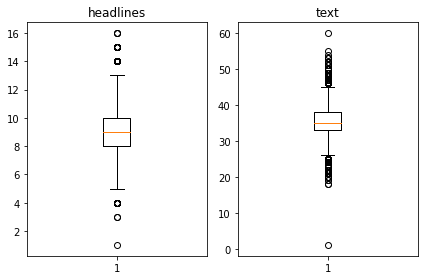

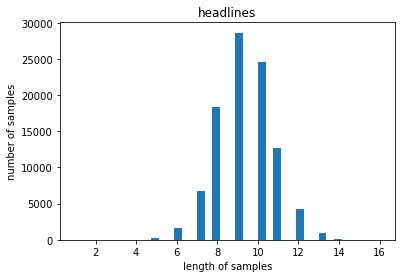

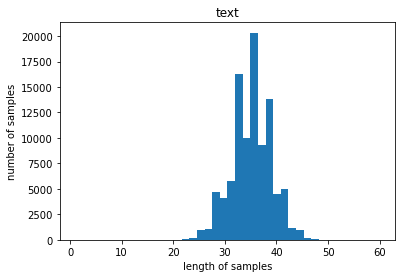

In [13]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [14]:
# 샘플 최대길히 제한

text_max_len = 41
headlines_max_len = 11

In [15]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [16]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 41 이하인 샘플의 비율: 0.9549613664091094
전체 샘플 중 길이가 11 이하인 샘플의 비율: 0.9449877999186661


In [17]:
# 최대길이보다 긴 데이터 제외

data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 88749


In [18]:
# 시작토큰, 종료토큰 추가

data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
7,govt directs alok verma to join work day befor...,weeks ex cbi director alok verma told departme...,sostoken govt directs alok verma to join work ...,govt directs alok verma to join work day befor...


In [19]:
# 인코더 입력, 디코더 입력, 레이블 각각 Numpy 타입으로 저장

encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [20]:
# 정수 시퀀스 생성

indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[55430 39916 59754 ... 82072 33218 47706]


In [21]:
# 정수 시퀀스를 이용하여 데이터 순서 재정의

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [22]:
#test set 비율 지정

n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 17749


In [23]:
# train, test 분리

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 71000
훈련 레이블의 개수 : 71000
테스트 데이터의 개수 : 17749
테스트 레이블의 개수 : 17749


In [24]:
# train 단어집합 생성

src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [25]:
#등장 빈도수 탐색

threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 66117
등장 빈도가 6번 이하인 희귀 단어의 수: 45048
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 21069
단어 집합에서 희귀 단어의 비율: 68.13376287490358
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.6937028197720356


In [26]:
#단어집합 크기 제한

src_vocab = 20000
src_tokenizer = Tokenizer(num_words = src_vocab) # 단어 집합의 크기를 20,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

In [27]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

#잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[67, 147, 12170, 85, 8136, 9837, 619, 5, 16, 123, 43, 160, 411, 35, 2535, 219, 10542, 343, 43, 375, 43, 124, 56, 391, 16519, 2609, 580, 3597, 106, 3689, 5, 179, 256, 6023, 546, 419, 990], [2, 3525, 1050, 1471, 894, 2610, 325, 559, 13429, 1211, 20, 1583, 1841, 453, 1112, 1112, 3075, 3525, 826, 4, 1566, 2634, 894, 583, 559, 22, 10054, 1112, 1185, 495, 7861, 106, 1298, 540, 6577], [353, 8877, 3340, 4052, 286, 300, 9838, 1194, 590, 3076, 95, 4615, 1174, 4052, 42, 2205, 1754, 2184, 1993, 1078, 183, 3779, 1, 4052, 241, 985, 7062, 365, 39, 651, 1194, 247, 4615, 5889, 4052, 42]]


In [28]:
# test 안어집합 생성

tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [29]:
# 빈도수 탐색

threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29020
등장 빈도가 5번 이하인 희귀 단어의 수: 19107
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9913
단어 집합에서 희귀 단어의 비율: 65.8407994486561
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.085287831657519


In [30]:
# 단어집합 크기 제한

tar_vocab = 9500
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

#잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 2808, 777, 4, 263, 28, 248, 4, 350, 122], [1, 8, 281, 17, 27, 865, 3078, 1075, 4, 1673, 1011], [1, 62, 79, 4350, 53, 2080, 8319, 4, 18, 15], [1, 6093, 195, 1776, 85, 2183, 59, 138, 33], [1, 1385, 5038, 322, 1454, 186, 11, 816, 172]]
target
decoder  [[2808, 777, 4, 263, 28, 248, 4, 350, 122, 2], [8, 281, 17, 27, 865, 3078, 1075, 4, 1673, 1011, 2], [62, 79, 4350, 53, 2080, 8319, 4, 18, 15, 2], [6093, 195, 1776, 85, 2183, 59, 138, 33, 2], [1385, 5038, 322, 1454, 186, 11, 816, 172, 2]]


In [31]:
# 길이가 1인 인덱스 탐색

drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 70999
훈련 레이블의 개수 : 70999
테스트 데이터의 개수 : 17749
테스트 레이블의 개수 : 17749


/home/aiffel-dj48/Downloads/aiffel/envs/aiffel/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [32]:
# 최대 길이에 맞게 패딩

encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = headlines_max_len, padding='post')

## 11.3 모델 생성(추상적 요약)

In [33]:
# 인코더 설계

from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [34]:
# 디코더 설계

decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

In [35]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 41)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 41, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 41, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [36]:
#어텐션 함수 다운로드

urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [37]:
#어텐션 적용

# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 41)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 41, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 41, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

## 11.4 모델 훈련(추상적 요약)

In [38]:
#훈련 진행

model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 50)

Epoch 1/50
278/278 [==============================] - 94s 338ms/step - loss: 5.9868 - val_loss: 5.5856
Epoch 2/50
278/278 [==============================] - 93s 336ms/step - loss: 5.4176 - val_loss: 5.1865
Epoch 3/50
278/278 [==============================] - 94s 338ms/step - loss: 5.0597 - val_loss: 4.8911
Epoch 4/50
278/278 [==============================] - 94s 337ms/step - loss: 4.7783 - val_loss: 4.6881
Epoch 5/50
278/278 [==============================] - 94s 338ms/step - loss: 4.5536 - val_loss: 4.5407
Epoch 6/50
278/278 [==============================] - 94s 337ms/step - loss: 4.3678 - val_loss: 4.4156
Epoch 7/50
278/278 [==============================] - 94s 337ms/step - loss: 4.2089 - val_loss: 4.3071
Epoch 8/50
278/278 [==============================] - 94s 338ms/step - loss: 4.0687 - val_loss: 4.2307
Epoch 9/50
278/278 [==============================] - 94s 339ms/step - loss: 3.9443 - val_loss: 4.1861
Epoch 10/50
278/278 [==============================] - 94s 340ms/step - l

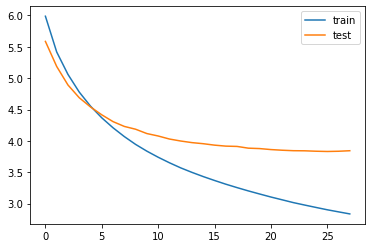

In [39]:
# loss 변화율 시각화

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 11.5 인퍼런스 모델 구현

In [40]:
#정수데이터 복원을 위한 사전 구성

src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [41]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [42]:
# 출력층 생성

# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [43]:
#단어시퀀스 함수 생성

def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

## 11.6 모델 테스트

In [44]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [45]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : central industrial security force personnel deployed airports sought replace bulletproof jackets ones withstand bullets fired ak rifles gunshots fired point blank range issue raised civil aviation ministry last month officials said airports high alert jackets important terror attacks officials added 
실제 요약 : cisf seeks bulletproof that ak bullets 
예측 요약 :  cisf to cisf security security for airports


원문 : nasa experimental mini satellites nicknamed wall eve disney characters broadcast status insight mars lander use compressed gas found fire push space way wall film insight first mission study deep interior mars track landing planet monday 
실제 요약 : nasa satellites wall eve to track robotic mars landing 
예측 요약 :  nasa shares image of spacex mars landing


원문 : big bang theory actress revealed thursday underwent surgery correct undisclosed medical issue five days wedding professional karl cook honeymoon shoulder surgery husband looks happy wrote post instagram got married karl calif

예측 요약 :  kejriwal remarks on kejriwal tweet on social media


원문 : amitabh bachchan confirmed back host ninth season quiz show kaun banega crorepati bachchan personal blog wrote contest air august september year revealed contestants spending many hours hot seat would end becoming dearest friends 
실제 요약 : bachchan to return as host of kaun banega crorepati season 
예측 요약 :  amitabh bachchan launches his season season


원문 : irctc tied startup self help group known supplying good quality mangoes deliver mangoes passengers seats move aimed promoting irctc catering services food track mangoes sold discounted price per dozen 
실제 요약 : irctc to get delivered to passengers seats 
예측 요약 :  startup to hire users to write gender neutral


원문 : kolkata called calcutta country biggest city population lakh delhi seventh populous city population delhi grew partition overtook chennai third populous city census mumbai overtook kolkata populous city 
실제 요약 : how have indian cities grown in yrs from to 
예

예측 요약 :  facebook admits to let users control ads using


원문 : said online travel agents liable deduct tax collected source gst classified commerce operators deduct tcs making payment suppliers also clarified benefit exemption gst businesses turnover lakh available commerce operators 
실제 요약 : online travel agents liable to tax at source 
예측 요약 :  tax returns to tax on under gst returns to


원문 : talking interview vision uttar pradesh chief minister yogi adityanath said government wants make developed state india want generate employment youngsters migrate different states added said months government made policies different sectors 
실제 요약 : want to make up most developed state in india cm yogi 
예측 요약 :  adityanath has not need to make up cm adityanath


원문 : growing evidence people eat fruits vegetables better mental health lower incidence depression anxiety greater happiness higher life satisfaction recommended intake fruits vegetables average intake india per day comprising fruits ve

## 11.7 데이터 준비(추출적 요약)

In [46]:
# 필요 모듈 import

import requests
from summa.summarizer import summarize

In [47]:
# 데이터 다운로드

urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
data.sample(10)

,headlines,text
34816,Cuba gets its first non-Castro President in 60...,Cuba's National Assembly has appointed First V...
47125,US nervous about N Korea striking with nukes: ...,Admitting that the North Korean threat to stri...
84590,"Delhi man takes wife to park for a surprise, s...",A 22-year-old woman was allegedly strangled to...
6678,"Isha Ambani, Anand Piramal's wedding to cost $...",Asia's richest person Mukesh Ambani's daughter...
9301,Tesla accidentally gives user access to 1.5 mi...,Elon Musk-led Tesla accidentally gave a forum ...
48464,Banks to accept only online applications for e...,The government has directed the banks to only ...
22804,"Illness, jail detention most cited reasons by ...","Illness, elections in their constituency and d..."
3700,PM fled Parliament to lecture Lovely Universit...,"After PM Narendra Modi's absence in Lok Sabha,..."
82280,No regional peace without Pakistan's cooperati...,"There could be ""no peace"" in Afghanistan or th..."
38710,Cong denies it didn't invite ex-Prez Pranab to...,The Congress has denied reports that it did no...


In [48]:
text = data['text']
print(text)

0        Saurav Kant, an alumnus of upGrad and IIIT-B's...
1        Kunal Shah's credit card bill payment platform...
2        New Zealand defeated India by 8 wickets in the...
3        With Aegon Life iTerm Insurance plan, customer...
4        Speaking about the sexual harassment allegatio...
                               ...                        
98396    A CRPF jawan was on Tuesday axed to death with...
98397    'Uff Yeh', the first song from the Sonakshi Si...
98398    According to reports, a new version of the 199...
98399    A new music video shows rapper Snoop Dogg aimi...
98400    Madhesi Morcha, an alliance of seven political...
Name: text, Length: 98401, dtype: object


In [49]:
newshead = data['headlines']
print(newshead)

0        upGrad learner switches to career in ML & Al w...
1        Delhi techie wins free food from Swiggy for on...
2        New Zealand end Rohit Sharma-led India's 12-ma...
3        Aegon life iTerm insurance plan helps customer...
4        Have known Hirani for yrs, what if MeToo claim...
                               ...                        
98396    CRPF jawan axed to death by Maoists in Chhatti...
98397    First song from Sonakshi Sinha's 'Noor' titled...
98398           'The Matrix' film to get a reboot: Reports
98399    Snoop Dogg aims gun at clown dressed as Trump ...
98400    Madhesi Morcha withdraws support to Nepalese g...
Name: headlines, Length: 98401, dtype: object


In [50]:
#summarize 활용 문장 줄이기
# 문장 퍼센티지로 요약
print('Summary:')
print(summarize(text[0], ratio=0.5))

Summary:
upGrad's Online Power Learning has powered 3 lakh+ careers.


In [51]:
# 출려결과 리스트로 받기
print('Summary:')
print(summarize(text[0], ratio=0.5, split=True))

Summary:
["upGrad's Online Power Learning has powered 3 lakh+ careers."]


In [52]:
# 단어 개수로 요약

print('Summary:')
print(summarize(text[0], words=50))

Summary:
Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience.
The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike.
upGrad's Online Power Learning has powered 3 lakh+ careers.


In [53]:
# 리스트에 요약문 담아내기
# 문장길이의 0.5로 요약

headlines = []
for i in range(len(text)) :
    headlines.append(summarize(text[i], ratio=0.5))

print(headlines[:10])

["upGrad's Online Power Learning has powered 3 lakh+ careers.", 'Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.', 'The match witnessed India getting all out for 92, their seventh lowest total in ODI cricket history.', 'Also, customers have options to insure against Critical Illnesses, Disability and Accidental Death Benefit Rider with a life cover up to the age of 80 years.', 'Speaking about the sexual harassment allegations against Rajkumar Hirani, Sonam Kapoor said, "I\'ve known Hirani for many years...What if it\'s not true, the [#MeToo] movement will get derailed." "In the #MeToo movement, I always believe a woman.', 'Pakistani singer Rahat Fateh Ali Khan has denied receiving any notice from the Enforcement Directorate over allegedly smuggling foreign currency out of India.', "India's previous lowest ODI total in New Zealand was 108.", 'Weeks after ex-CBI Director Alok Verma told th

In [54]:
#원문과 비교해보기


for i in range(10, 50):
    print("원문 :", text[i])
    print("실제 요약 :", newshead[i])
    print("예측 요약 :", headlines[i])
    print("\n")

원문 : Two minor cousins in Uttar Pradesh's Gorakhpur were allegedly repeatedly burnt with tongs and forced to eat human excreta by their family for being friends with two boys from the same school. The cousins revealed their ordeal to the police and Child Welfare Committee after being brought back to Gorakhpur from Nepal, where they had fled to escape the torture.
실제 요약 : UP cousins fed human excreta for friendship with boys
예측 요약 : Two minor cousins in Uttar Pradesh's Gorakhpur were allegedly repeatedly burnt with tongs and forced to eat human excreta by their family for being friends with two boys from the same school.


원문 : Isha Ghosh, an 81-year-old member of Bharat Scouts and Guides (BSG), has been imparting physical and mental training to schoolchildren in Jharkhand for several decades. Chaibasa-based Ghosh reportedly walks seven kilometres daily and spends eight hours conducting physical training, apart from climbing and yoga sessions. She says, "One should do something for soci

적당히 나온것 같다

# 느낀점
프로젝트 진행 자체는 비교적 원활하게 진행되었으나 전체 개념을 이해하는데 어려움을 겪었다.
요약결과물이 잘 나온건지는 영어울렁증으로 인해 직접 비교해보지 못하여 그저 비슷한 단어가 있는것으로 보아 대충 어느정도 나왔구나 하고 있다.

갈수록 프로젝트에서 제시하는 코드는 직관적이지만 거기에 적용되는 개념이 심화되어 학습에 어려움이 있다. 조금 더 개념이해에 투자하는 시간을 늘릴필요가 있어보인다.